# Estimating $\pi$ using Quantum Phase Estimation

### Import section

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

import numpy as np
from math import pi

from qiskit import *
from qiskit_aer import QasmSimulator, UnitarySimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import *


## Prepare all the ingredients

In [4]:
# define inverse QFT function
def inv_qft(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu(0,-pi/float(2**(j-m)),0,0, m, j)
        circ.h(j)

In [13]:
def preparation(circ_,n):
    circ_.h(range(n))
    circ_.x(n)
    
    for x in reversed(range(n)):
        for _ in range(2**(n-1-x)):
            circ_.cu(0,1,0,0,n-1-x,n)

In [25]:
def run_job(circ_, backend_, shots_=8192, optimization_level_=0):
    job = backend_.run(circ_.decompose(), shots= shots_, optimization_level=optimization_level_)
    #job_monitor(job)
    return job.result().get_counts(circ_)

## function to estimate $\pi$

In [26]:
def pi_estimate(n):
    
    # create a circuit
    qc = QuantumCircuit(n+1,n)
    # prepare the state
    preparation(qc,n)
    
    qc.barrier()
    # apply inverse QFT
    inv_qft(qc,n)
    
    qc.barrier()
    
    # measure all but the last qubits
    qc.measure(range(n),range(n))
    
    if n<10:
        qc.draw('mpl')
        
    counts = run_job(qc, QasmSimulator(), shots_ = 8000)
    
    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    max_counts_result = int(max_counts_result, 2)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n
    return (1./(2*theta))

In [27]:
# estimate pi using different numbers of qubits
nqs = list(range(2,12+1))
pi_est = []
for nq in nqs:
    thisnq_pi_estimate = pi_estimate(nq)
    pi_est.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

2 qubits, pi ≈ 2.0
3 qubits, pi ≈ 4.0
4 qubits, pi ≈ 2.6666666666666665
5 qubits, pi ≈ 3.2
6 qubits, pi ≈ 3.2
7 qubits, pi ≈ 3.2
8 qubits, pi ≈ 3.1219512195121952
9 qubits, pi ≈ 3.1604938271604937
10 qubits, pi ≈ 3.1411042944785277
11 qubits, pi ≈ 3.1411042944785277
12 qubits, pi ≈ 3.1411042944785277


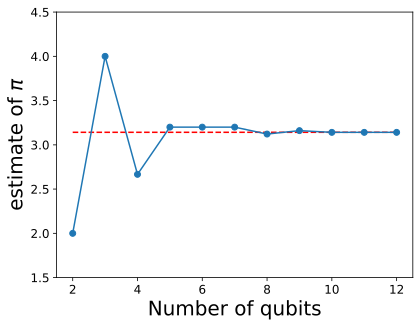

In [28]:
plt.plot(nqs, [pi]*len(nqs), '--r')
plt.plot(nqs, pi_est, '.-', markersize=12)
plt.xlim([1.5, 12.5])
plt.ylim([1.5, 4.5])
#plt.legend(['$\pi$', 'estimate of $\pi$'])
plt.xlabel('Number of qubits', fontdict={'size':20})
plt.ylabel('estimate of $\pi$', fontdict={'size':20})
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()